In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

SEED = 42
np.random.seed(SEED)

In [ ]:
train_df = pd.read_csv('playground-series-s6e2/train.csv')
test_df = pd.read_csv('playground-series-s6e2/test.csv')

train_df['Heart Disease'] = train_df['Heart Disease'].map({'Absence': 0, 'Presence': 1})

In [ ]:
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("Class balance:\n", train_df['Heart Disease'].value_counts(normalize=True))

Train shape: (630000, 15)
Test shape: (270000, 14)
Class balance:
 Heart Disease
0    0.55166
1    0.44834
Name: proportion, dtype: float64


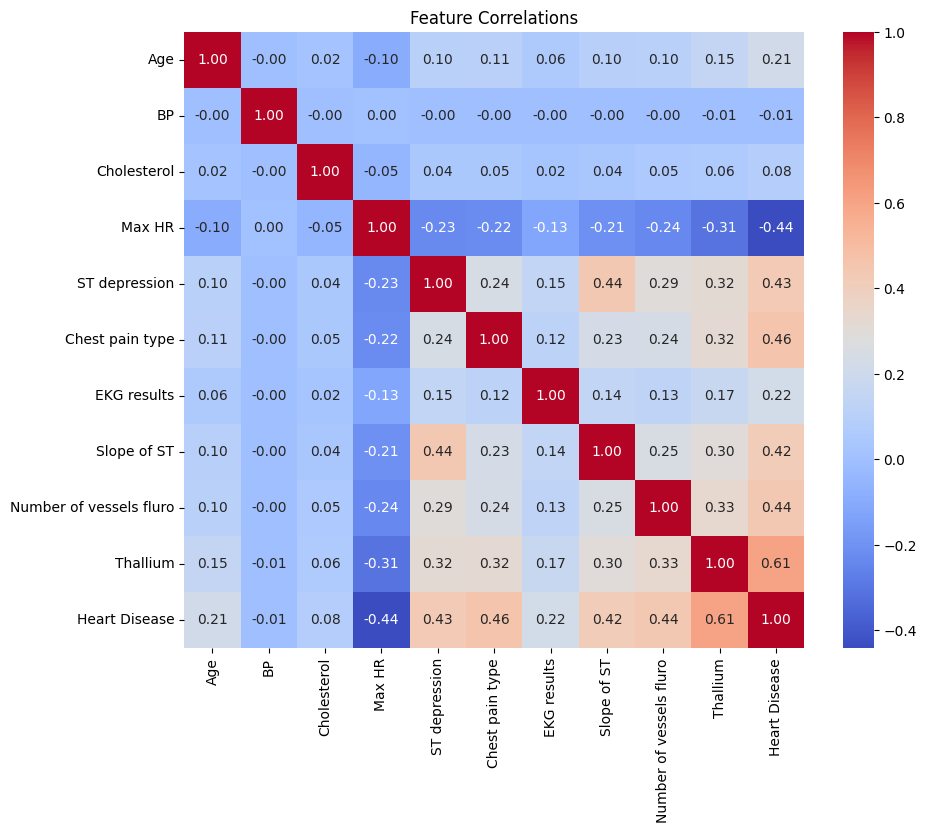

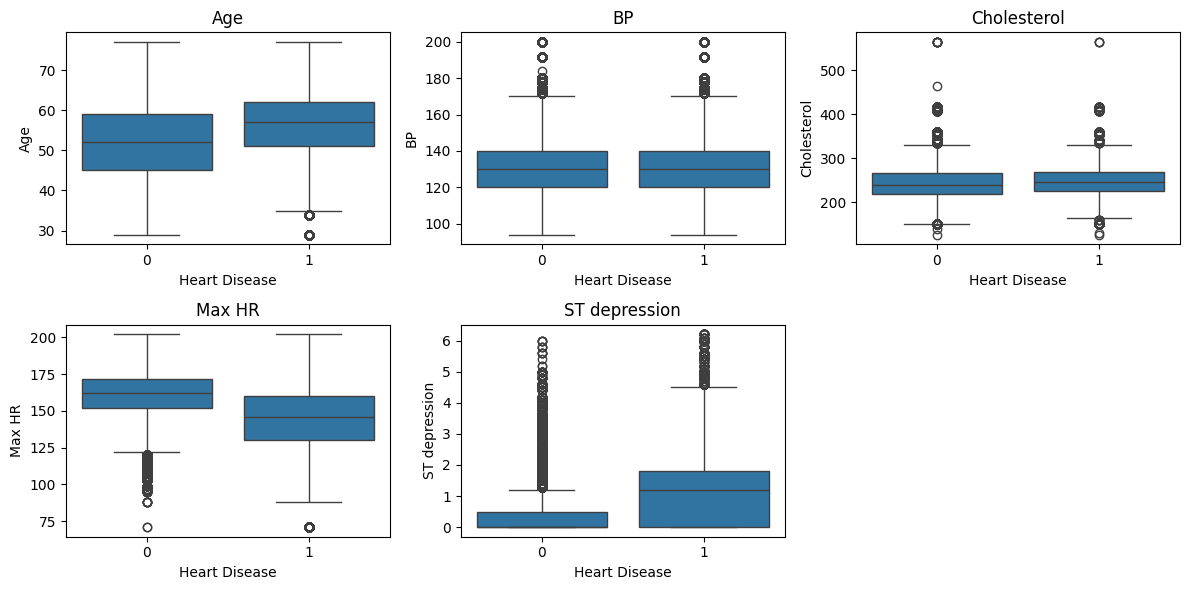

In [ ]:
continuous_cols = ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']
ordinal_cols = ['Chest pain type', 'EKG results', 'Slope of ST', 'Number of vessels fluro', 'Thallium']

plt.figure(figsize=(10, 8))
sns.heatmap(train_df[continuous_cols + ordinal_cols + ['Heart Disease']].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlations")
plt.show()

plt.figure(figsize=(12, 6))
for i, col in enumerate(continuous_cols):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='Heart Disease', y=col, data=train_df)
    plt.title(col)
plt.tight_layout()
plt.show()

In [ ]:
X = train_df.drop('Heart Disease', axis=1)
y = train_df['Heart Disease']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=SEED
)

In [ ]:
feature_names = list(X.columns)
print("Features used:", feature_names)

Features used: ['id', 'Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120', 'EKG results', 'Max HR', 'Exercise angina', 'ST depression', 'Slope of ST', 'Number of vessels fluro', 'Thallium']


In [ ]:
model = CatBoostClassifier(
    iterations=6000,
    learning_rate=0.015,
    depth=6,
    l2_leaf_reg=6,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=SEED,
    verbose=500,
    allow_writing_files=False
)

In [ ]:
model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    early_stopping_rounds=200,
    use_best_model=True
)

0:	test: 0.9397011	best: 0.9397011 (0)	total: 90ms	remaining: 9m
500:	test: 0.9550591	best: 0.9550591 (500)	total: 13.9s	remaining: 2m 32s
1000:	test: 0.9555772	best: 0.9555772 (1000)	total: 27.1s	remaining: 2m 15s
1500:	test: 0.9559361	best: 0.9559361 (1500)	total: 40.3s	remaining: 2m
2000:	test: 0.9560810	best: 0.9560811 (1999)	total: 53.5s	remaining: 1m 46s
2500:	test: 0.9561530	best: 0.9561531 (2492)	total: 1m 6s	remaining: 1m 33s
3000:	test: 0.9561907	best: 0.9561911 (2995)	total: 1m 19s	remaining: 1m 19s
3500:	test: 0.9562062	best: 0.9562064 (3487)	total: 1m 32s	remaining: 1m 6s
4000:	test: 0.9562149	best: 0.9562157 (3922)	total: 1m 45s	remaining: 52.9s
4500:	test: 0.9562188	best: 0.9562212 (4369)	total: 1m 57s	remaining: 39.3s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9562212044
bestIteration = 4369

Shrink model to first 4370 iterations.


In [ ]:
val_preds = model.predict_proba(X_val)[:, 1]
val_ll = log_loss(y_val, val_preds)
val_auc = roc_auc_score(y_val, val_preds)

print(f"Validation Log Loss: {val_ll:.5f}")
print(f"Validation AUC: {val_auc:.5f}")

Validation Log Loss: 0.26537
Validation AUC: 0.95622


In [ ]:
best_eps = 0
min_ll_clip = float('inf')

for eps in [0.005, 0.01, 0.02]:
    clipped_preds = np.clip(val_preds, eps, 1 - eps)
    ll = log_loss(y_val, clipped_preds)
    print(f"Eps: {eps}, LogLoss: {ll:.5f}")
    if ll < min_ll_clip:
        min_ll_clip = ll
        best_eps = eps

print(f"Best clipping eps: {best_eps} with LogLoss: {min_ll_clip:.5f}")

Eps: 0.005, LogLoss: 0.26551
Eps: 0.01, LogLoss: 0.26598
Eps: 0.02, LogLoss: 0.26755
Best clipping eps: 0.005 with LogLoss: 0.26551


In [ ]:
lr_calibrator = LogisticRegression(C=1.0, solver='lbfgs')
lr_calibrator.fit(val_preds.reshape(-1, 1), y_val)

platt_preds = lr_calibrator.predict_proba(val_preds.reshape(-1, 1))[:, 1]
platt_ll = log_loss(y_val, platt_preds)

print(f"Platt Scaling LogLoss: {platt_ll:.5f}")

use_platt = False
if platt_ll < min_ll_clip:
    print("Selecting Platt Scaling.")
    use_platt = True
else:
    print(f"Selecting Clipping (eps={best_eps}).")

Platt Scaling LogLoss: 0.27759
Selecting Clipping (eps=0.005).


In [ ]:
model.fit(
    X, y,
    verbose=500
)

0:	total: 34.4ms	remaining: 3m 26s
500:	total: 12.7s	remaining: 2m 19s
1000:	total: 24.5s	remaining: 2m 2s
1500:	total: 36.1s	remaining: 1m 48s
2000:	total: 47.7s	remaining: 1m 35s
2500:	total: 1m	remaining: 1m 24s
3000:	total: 1m 12s	remaining: 1m 12s
3500:	total: 1m 24s	remaining: 1m
4000:	total: 1m 37s	remaining: 48.6s
4500:	total: 1m 50s	remaining: 36.7s
5000:	total: 2m 3s	remaining: 24.6s
5500:	total: 2m 15s	remaining: 12.3s
5999:	total: 2m 28s	remaining: 0us


In [ ]:
test_preds_raw = model.predict_proba(test_df)[:, 1]

if use_platt:
    final_preds = lr_calibrator.predict_proba(test_preds_raw.reshape(-1, 1))[:, 1]
else:
    final_preds = np.clip(test_preds_raw, best_eps, 1 - best_eps)

In [ ]:
submission = pd.DataFrame({
    'id': test_df.index if 'id' not in test_df.columns else test_df['id'],
    'Heart Disease': final_preds
})

submission.to_csv('submissionCat.csv', index=False)
print("Submission saved to submissionCat.csv")
print(submission.head())

Submission saved to submissionCat.csv
       id  Heart Disease
0  630000       0.951081
1  630001       0.006602
2  630002       0.991004
3  630003       0.005000
4  630004       0.240268
